In [1]:
from plt_bulk import bulk_disp
import numpy as np
from collections import deque
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
#
alat = 14.5533

direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
#
recip = np.array([[ 1.121488, -0.647491,  0.388815],  
                  [ -0.000000,  1.294983, 0.388815],  
                  [ -1.121488, -0.647491,  0.388815]] ) 
#

In [2]:
param = np.zeros(11)
param[0] = 2.0 
param[1] = 2.0 
param[2] = -0.5 
param[3] = -0.15
param[5] = +0.05

param_k = [0.0,0.0, 3.29, 0.57, 0.00, -0.07, 0.19, 0.31, 0.47, 0.0, 0.04]
par_k_dm = param_k.copy()
par_k_dm[4] = 0.07
param_k_noil = param_k[:6] + 5*[0.] 
type(param_k_noil[6:]) ,param_k_noil


(list, [0.0, 0.0, 3.29, 0.57, 0.0, -0.07, 0.0, 0.0, 0.0, 0.0, 0.0])

In [3]:
inp = {
			 'param':-np.array(param_k), 
			 'S':3.0/2.0}
#
inp_dm = { 'param': -np.array(par_k_dm), 'S':3./2.}
k = np.array([1./3.,-1./3.,0.0])
zs = np.array([0.3333333,0.333333,0.3333333])

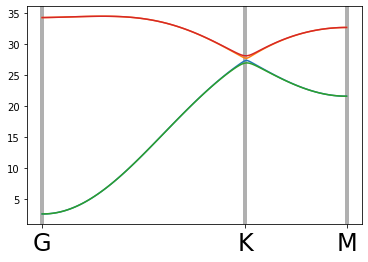

In [4]:
lspace= np.linspace(0.0,1.5,num=120)
gk0 = [bulk_disp(*(c*k+0.5*zs), branch=0,**inp) for c in lspace] 
gk1 = [bulk_disp(*(c*k+0.5*zs), branch=1,**inp) for c in lspace]
gk0dm = [bulk_disp(*(c*k+0.5*zs), branch=0,**inp_dm) for c in lspace] 
gk1dm = [bulk_disp(*(c*k+0.5*zs), branch=1,**inp_dm) for c in lspace]
K = k.dot(recip)
h1 = np.array([1,-1,0]).dot(direct)
a_hex = np.sqrt((h1.dot(h1)))
sk = np.sqrt(K.dot(K))/a_hex
gkascissa = [c*sk for c in lspace]
#
K = k.dot(recip)  
m1 = np.sqrt(K.dot(K))
Kp = recip[0] -recip[2]
m2 = np.sqrt(Kp.dot(Kp))

plt.plot(gkascissa,gk0)
plt.plot(gkascissa,gk1)
plt.plot(gkascissa,gk0dm)
plt.plot(gkascissa,gk1dm)
plt.grid (visible=True, axis='x')
plt.xticks([0,sk,1.5*sk],['G','K','M'], size=24)
plt.tick_params(grid_linewidth=4)

In [5]:
d = np.array([[0.1,0.0,0.0],[0.0,0.1,0.0],[0.0,0.0,0.1]])
d_frac= direct.T.dot(d)
d_frac[1].dot(recip)

array([ 0.0000000e+00,  9.9999986e-02, -3.8881500e-08])

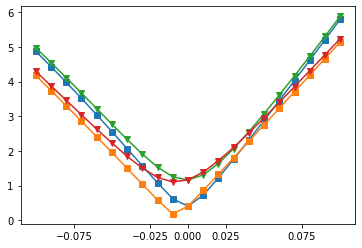

In [6]:
dodline = lambda dir,branch: [bulk_disp(*(k+c*d_frac[dir]),branch=branch, **inp) for c in np.linspace(-1.0,1.0,21)]
gap = lambda q,inp_: bulk_disp(*q,branch=1,**inp_)-bulk_disp(*q,branch=0, **inp_)
gapline = lambda dir,inp_=inp:[gap(k+c*d_frac[dir] + 0.5 * zs,inp_) for c in np.linspace(-1.0,1.0,21)]

gdx1 = dodline(dir=0,branch=0)
gdx2 = dodline(dir=0,branch=1)
gdy1 = dodline(dir=1,branch=0)
gdy2 = dodline(dir=1,branch=1)
gap1 = gapline(0)


#plt.plot(np.linspace(-1,1,21), gdx2,marker='o')
#plt.plot(np.linspace(-1,1,21), gdx1, marker='o')
#plt.plot(np.linspace(-1,1,21), gdy1, marker='o')
#plt.plot(np.linspace(-1,1,21), gdy2, marker='o')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(0), marker='s')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(1), marker='s')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(0,inp_dm), marker='v')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(1,inp_dm), marker='v')
plt.xticks([-0.075,-0.025,0.0, 0.025, 0.075])
plt.show()

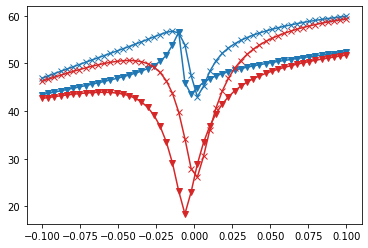

In [7]:
def gap_grad(o, disp, parms, v='bck'):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    dx_frac = direct.T.dot([[disp,0.0,0.0],
                          [0.0,disp,0.0],
                          [0.0,0.0,disp]
                         ])
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    
    go = gap(o)
    if v == 'fw':
        dgx = (gap(o+dx_frac[0])-go)/disp
        dgy = (gap(o+dx_frac[1])-go)/disp
    elif v == 'bck':
        dgx = (go - gap(o-dx_frac[0]))/disp
        dgy = (go - gap(o-dx_frac[1]))/disp
    elif v == 'both':
        dgx = ((gap(o+dx_frac[0])- gap(o-dx_frac[0]))/disp)/2.0
        dgy = ((gap(o+dx_frac[1])- gap(o-dx_frac[1]))/disp)/2.0
    return np.array([dgx,dgy])

g = lambda s,d,par: gap_grad(k+s*d_frac[d]+0.5*zs,0.00001, par, v='bck')
gline = [np.sqrt(g(s,0,inp).dot(g(s,0,inp))) for s in np.linspace(-1.0,1.0,50)]
gline2 = [np.sqrt(g(s,1,inp).dot(g(s,1,inp))) for s in np.linspace(-1.0,1.0,50)]
gline_dm = [np.sqrt(g(s,0,inp).dot(g(s,0,inp_dm))) for s in np.linspace(-1.0,1.0,50)]
gline2_dm = [np.sqrt(g(s,1,inp).dot(g(s,1,inp_dm))) for s in np.linspace(-1.0,1.0,50)]
#
col1 = '#1f77b4'
col2 = '#d62728'
a = plt.plot(0.1*np.linspace(-1.0,1.0,50), gline,marker='x',color = col1)
plt.plot(0.1*np.linspace(-1.0,1.0,50), gline2,marker='v', color=col1)
plt.plot(0.1*np.linspace(-1.0,1.0,50), gline_dm, marker='x',color=col2)
b = plt.plot(0.1*np.linspace(-1.0,1.0,50), gline2_dm, marker='v',color=col2)

In [8]:
def jac(o, disp, parms):
  direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
  dx_frac = direct.T.dot([[disp,0.0,0.0],
                          [0.0,disp,0.0],
                          [0.0,0.0,disp]])
  gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
  
  go = gap(o)
  gpx = gap (o + dx_frac[0])
  gmx = gap (o - dx_frac[0])
  gpy = gap (o + dx_frac[1])
  gmy = gap (o - dx_frac[1])
  gpxy = gap (o + dx_frac[0] + dx_frac[1] )
  gmxy = gap (o - dx_frac[0] - dx_frac[1] )
  dxx = (gpx + gmx - 2 * go) / 2 /disp**2 
  dyy = (gpy + gmy - 2 * go) / 2 /disp**2 
  dxy = ((gpxy + go - gpx -gpy))/disp**2 
  return np.array([[dxx,dxy],[dxy,dyy]]) 


In [9]:
def steepest_descent_gap(o, disp,parms, v='bck'):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    g = gap(o)
    grad = gap_grad(o,disp, parms, v)
    new_q_2D = (-g/grad.dot(grad)) * grad
    new_q_3D = np.array([new_q_2D[0],new_q_2D[1], 0.0])
    new_q_frac = o + direct.dot(new_q_3D)
    return(gap(new_q_frac)) 
    
def newton_scf_gap(o, disp,parms):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    g = gap(o)
    grad = gap_grad(o,disp, parms, v='both')
    hess = jac(o, disp, parms)
    dr  = (-g/grad.dot(grad)) * grad 
    grad2 = grad + 0.5 *  hess.dot(dr)
    dr2 =  (-g/grad2.dot(grad2)) * grad2  
    new_q_3D = np.array([dr2[0],dr2[1], 0.0])
    new_q_frac = o + direct.dot(new_q_3D)
    return(gap(new_q_frac)) 

def newton_gap(o, disp,parms):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    g = gap(o)
    grad = gap_grad(o,disp, parms, v='both')
    hess = jac(o, disp, parms)
    s = grad/np.sqrt(grad.dot(grad)) 
    modgrad = grad.dot(s) 
    d2gds2 = (s.dot(hess)).dot(s)  
    alpha = (-modgrad + np.sqrt(modgrad**2 - 2 * d2gds2 * g))/d2gds2 
    dr2 =  alpha * s 
    new_q_3D = np.array([dr2[0],dr2[1], 0.0])
    new_q_frac = o + direct.dot(new_q_3D)
    return(gap(new_q_frac))

def newton_min_gap(o,disp,parms):
  direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
  gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
  g = gap(o)
  grad = gap_grad(o,disp, parms, v='both')
  hess = jac(o, disp, parms)
  hi =np.array(np.matrix(hess).I)
  dr2 = -hi.dot(grad)
  new_q_3D = np.array([dr2[0],dr2[1], 0.0])
  new_q_frac = o + direct.dot(new_q_3D)
  return(gap(new_q_frac)) 

/tmp/ipykernel_7640/3273097243.py:42: RuntimeWarning: invalid value encountered in sqrt
  alpha = (-modgrad + np.sqrt(modgrad**2 - 2 * d2gds2 * g))/d2gds2


(-0.027500000000000004, 0.027500000000000004, -0.026646961446166986, 0.3)

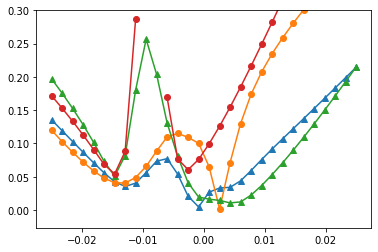

In [10]:
lspace = np.linspace(-.25,0.25,30)
gs = lambda s,d,par:  steepest_descent_gap(k+s*d_frac[d]+0.5*zs,0.001,par,v='both')
gs2 = lambda s,d,par: newton_scf_gap(k+s*d_frac[d]+0.5*zs,0.005,par)
ghs = lambda s,d,par: newton_gap(k+s*d_frac[d]+0.5*zs,0.005,par) 
gsline  = [gs2(s,0,inp) for s in lspace]
ghsline = [ghs(s,0,inp) for s in lspace]
gsline1 = [gs2(s,1,inp) for s in lspace]
ghsline1 = [ghs(s,1,inp) for s in lspace]
gapline = lambda dir,inp_,spc=inp:[gap(k+c*d_frac[dir],inp_) for c in spc]
gaps = gapline(0,inp, lspace)
plt.plot(0.1 * lspace, gsline,marker='^')
plt.plot(0.1*lspace,ghsline, marker='o')
plt.plot(0.1 * lspace, gsline1, marker='^')
plt.plot(0.1 * lspace, ghsline1, marker='o')
_ = plt.axis()
plt.axis([_[0],_[1],_[2],0.3])
#plt.plot(0.1*lspace, gaps, color = 'red')


In [11]:
hess = jac(k,0.001,inp)
grad = gap_grad(k, 0.001,inp, v= 'both')
dr = -gap(k,inp)/grad.dot(grad) *grad 
grad2 = grad +  0.5*hess.dot(dr)
dr2 = -gap(k,inp)/grad2.dot(grad2) *grad2
dr2 = np.array(np.matrix(hess).I.dot(grad))[0]
dr2


array([ 0.04028864, -0.0350011 ])

In [12]:
t = direct.T.dot([[0.1,0.0,0.0],[0.0,0.1,0.0],[0.0,0.0,0.1]])
t

array([[ 0.0445836,  0.       , -0.0445836],
       [-0.0257404,  0.0514807, -0.0257404],
       [ 0.0857306,  0.0857306,  0.0857306]])

In [13]:
t[1].dot(recip[:,1])

0.09999998600090002

In [14]:
v = np.array([0.12,0.21,0.0])
fr = direct.dot(v)
fr[0]*recip[0]+fr[1]*recip[1]+fr[2]*recip[2]

array([ 1.19999934e-01,  2.09999971e-01, -8.16511500e-08])

In [15]:
k_disp = k + direct.dot(np.array([0.01,0,0]))
k_disp, k_disp.dot(recip)-k.dot(recip)


(array([ 0.33779169, -0.33333333, -0.00445836]),
 array([9.99999448e-03, 0.00000000e+00, 5.20417043e-18]))

In [16]:
inp

{'param': array([-0.  , -0.  , -3.29, -0.57, -0.  ,  0.07, -0.19, -0.31, -0.47,
        -0.  , -0.04]),
 'S': 1.5}

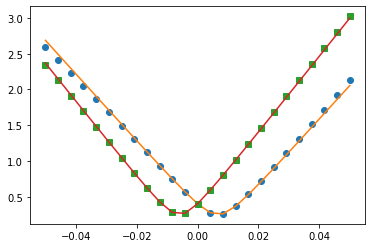

In [17]:
lspace =  np.linspace(-0.5, 0.5, 25) 
def gap_prova(x,k0x, k0y, hxx, hxy, hyy, beta):
  delta_k = x - np.array([k0x,k0y]) 
  h = np.array([[hxx,hxy],[hxy,hyy]])
  if (delta_k.dot(h)).dot(delta_k) + beta > 0.:
    return np.sqrt((delta_k.dot(h)).dot(delta_k) + beta) 
  else:
    return 0
#
def gap_prova_v(xv, k0x, k0y, hxx,hxy,hyy, beta):
  return [gap_prova(_, k0x, k0y, hxx,hxy,hyy, beta) for _ in xv] 
#
kxky_dir = lambda q: q.dot(recip)[0:2]
xdata = [kxky_dir(k+s*d_frac[0]) for s in  lspace] 
xdata2 =[kxky_dir(k+s*d_frac[1]) for s in  lspace] 
#
ydata = [gap(k+s*d_frac[0],inp) for s in lspace]
ydata2 = [gap(k+s*d_frac[1],inp) for s in lspace]
#
#
p = curve_fit(gap_prova_v, xdata,ydata,p0=[k.dot(recip)[0], k.dot(recip)[1],   1,0,1,0],
              maxfev= 1000, sigma=np.full_like(ydata,0.01))
p2 = curve_fit(gap_prova_v, xdata2,ydata2,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0], 
               maxfev=1000, sigma=np.full_like(ydata2,0.01))
#
xdata3 = xdata+xdata2 
ydata3 = ydata+ydata2
p3 = curve_fit(gap_prova_v, xdata3,ydata3,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0], 
               maxfev=1000, sigma=np.full_like(ydata3,0.01))
#
datamesh = [kxky_dir(k+i*s*d_frac[0]+j*s*d_frac[1]) for s in [0.1,] 
            for i,j  in [(0,0),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,-1)]]
ymesh =  [gap(k+i*s*d_frac[0]+j*s*d_frac[1],inp) for s in [0.1,] 
          for i,j  in [(0,0),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,-1)]]
p4 = curve_fit(gap_prova_v, datamesh, ymesh,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0] 
               ,maxfev=1000, sigma=np.full_like(ymesh,0.01))
fitted = [gap_prova(x_,*p4[0]) for x_ in xdata]
fitted2 = [gap_prova(x_,*p4[0]) for x_ in xdata2]
plt.plot(0.1*lspace, ydata, 'o')
plt.plot(0.1*lspace,fitted)
plt.plot(0.1*lspace, ydata2,'s')
plt.plot(0.1*lspace, fitted2)


In [18]:
p[0],p2[0],p3[0],p4[0], k.dot(recip)[0:2]

(array([ 3.80263682e-01, -5.79374915e-01,  2.20938138e+03, -1.32261481e+01,
         1.58463782e+01, -5.56930652e-03]),
 array([ 6.30835378e-01, -6.54882463e-01,  1.01612141e+00,  1.41731951e+01,
         2.86051288e+03, -6.48372405e-04]),
 array([ 3.79615491e-01, -6.53309180e-01,  2.20051811e+03, -1.16176559e+02,
         2.86908122e+03, -2.01551761e-02]),
 array([ 3.79221311e-01, -6.52220230e-01,  2.22369149e+03, -6.28557368e+02,
         2.85335735e+03,  2.38754960e-03]),
 array([ 0.37382933, -0.64749133]))

In [19]:
np.sqrt(np.diagonal(p4[1]))

array([1.96520674e-04, 1.46740976e-04, 6.87608873e+01, 5.57667342e+01,
       7.11266422e+01, 3.35111823e-03])

In [20]:
pdirac_est  = np.array([p4[0][0],p4[0][1],0.0])
pdirac_frac = direct.dot(pdirac_est)
gap(pdirac_frac,inp), np.sqrt(p4[0][-1])

(0.006312723267171805, 0.04886255830484318)

In [21]:
k_oscar = np.array([0.00, 0.3333333, -0.3333333])
k_line =3*k_oscar
q_oscar0 = k_oscar.dot(recip)
q_oscar1 = np.array([0.38382933, 0.64749133, 0.00000]) 
q_oscar2 = np.array([0.37382933, 0.63749133, 0.00000]) 
q_oscar3 = np.array([0.36382933, 0.64749133, 0.00000])
q_oscar4 = np.array([0.37382933, 0.65749133, 0.00000])
q_oscar5 = np.array([0.38382933, 0.63749133, 0.00000]) 
q_oscar6 = np.array([0.36382933, 0.65749133, 0.00000]) 

q_oscar = [q_oscar0, q_oscar1, q_oscar2,q_oscar3, q_oscar4, q_oscar5,q_oscar6] 
q_oscar

[array([0.3738293 , 0.64749127, 0.        ]),
 array([0.38382933, 0.64749133, 0.        ]),
 array([0.37382933, 0.63749133, 0.        ]),
 array([0.36382933, 0.64749133, 0.        ]),
 array([0.37382933, 0.65749133, 0.        ]),
 array([0.38382933, 0.63749133, 0.        ]),
 array([0.36382933, 0.65749133, 0.        ])]

In [22]:
q_oscar_frac = [direct.dot(_) for _ in q_oscar ]
oscar_x = [_[0:2] for _ in q_oscar] 
oscar_y = [0.51, 0.74, 1.13, 0.77, 0.27, 1.19, 0.52] 
p_oscar = curve_fit(gap_prova_v, oscar_x, oscar_y, p0= [k_oscar.dot(recip)[0], k_oscar.dot(recip)[1],1,0,1,0],sigma=np.full_like(oscar_y,0.03),maxfev=2000)

In [23]:
#np.sqrt(np.diagonal(p_dm[1]))

In [39]:
np.round([[*p_oscar[0][0:2],0.0]],8) 

array([[0.37255737, 0.65496811, 0.        ]])

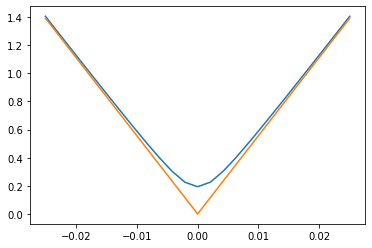

In [25]:
p_dirac_oscar = np.array([p_oscar[0][0], p_oscar[0][1],0.0])
pd_frac = direct.dot(p_dirac_oscar)
linea_plot =  [kxky_dir(pd_frac + s * d_frac[0]) for s in 0.5*lspace ]
fitted_oscar = [ gap_prova(x_, *p_oscar[0]) for x_ in linea_plot]
p_oscar_cono = p_oscar[0].copy()
p_oscar_cono[-1] = 0.e0
oscar_cono = [ gap_prova(x_, *p_oscar_cono) for x_ in linea_plot]
plt.plot (0.1*0.5*lspace, fitted_oscar) 
plt.plot (0.1*0.5*lspace, oscar_cono )

In [26]:
p_oscar[0]

array([3.72557374e-01, 6.54968110e-01, 3.10228408e+03, 6.91102595e+02,
       4.12934974e+03, 3.73821697e-02])

In [27]:
np.sqrt(p_oscar[0][-1])

0.19334469146963085

In [28]:
np.sqrt(np.diagonal(p_oscar[1]))     

array([5.66112604e-05, 6.01161122e-05, 4.69643129e+01, 3.15996202e+01,
       4.54465687e+01, 2.04503412e-03])

In [29]:
gap_prova(kxky_dir(pd_frac),*p_oscar[0])

0.19334469196619367

Text(0.5, 1.0, 'Gap along lines crossing the "Dirac point"')

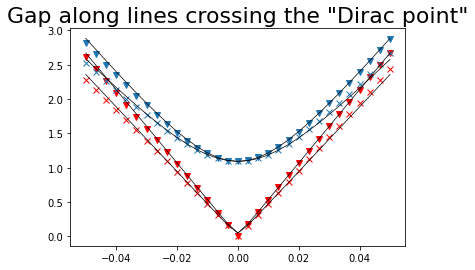

In [31]:
datamesh = [kxky_dir(k+i*s*d_frac[0]+j*s*d_frac[1]) 
            for s in [0.1,] for i,j  in [(0,0),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,-1)]]
#
ymesh =  [gap(k+i*s*d_frac[0]+j*s*d_frac[1],inp) 
          for s in [0.1,] for i,j  in [(0,0),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,-1)]]
ymesh_dm =  [gap(k+i*s*d_frac[0]+j*s*d_frac[1],inp_dm) 
          for s in [0.1,] for i,j  in [(0,0),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,-1)]]
#
p = curve_fit(gap_prova_v, datamesh, ymesh,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0] ,
               maxfev=1000, sigma=np.full_like(ymesh,0.01))
#
p_dm = curve_fit(gap_prova_v, datamesh, ymesh_dm,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0] ,
               maxfev=1000, sigma=np.full_like(ymesh,0.01))
#
#
#
pdirac_est  = np.array([p[0][0],p[0][1],0.0])
pdirac_frac = direct.dot(pdirac_est)
#
pdirac_est  = np.array([p_dm[0][0],p_dm[0][1],0.0])
pdirac_frac_dm = direct.dot(pdirac_est)
#
lspace = np.linspace(-0.5,0.5,31)
linex = [gap(pdirac_frac + s * d_frac[0],inp) for s in lspace]
liney = [gap(pdirac_frac + s * d_frac[1],inp) for s in lspace]
linex_dm = [gap(pdirac_frac_dm + s * d_frac[0],inp_dm) for s in lspace]
liney_dm = [gap(pdirac_frac_dm + s * d_frac[1],inp_dm) for s in lspace]
#
dati_per_curva_fit = [kxky_dir(pdirac_frac + s * d_frac[0]) for s in lspace ]
fitted1 = [gap_prova(x_,*p[0]) for x_ in dati_per_curva_fit]
#
dati_per_curva_fit = [kxky_dir(pdirac_frac + s * d_frac[1]) for s in lspace ]
fitted2 = [gap_prova(x_,*p[0]) for x_ in dati_per_curva_fit]
#
#
dati_per_curva_fit = [kxky_dir(pdirac_frac + s * d_frac[0]) for s in lspace ]
fitted1_dm = [gap_prova(x_,*p_dm[0]) for x_ in dati_per_curva_fit]
#
dati_per_curva_fit = [kxky_dir(pdirac_frac + s * d_frac[1]) for s in lspace ]
fitted2_dm = [gap_prova(x_,*p_dm[0]) for x_ in dati_per_curva_fit]
#
plt.plot(0.1*lspace, linex, 'x', color ='red')
plt.plot(0.1*lspace, liney, 'v', color='red')
#
plt.plot(0.1*lspace, linex_dm, 'x', color = '#1f77b4' )
plt.plot(0.1*lspace, liney_dm, 'v', color='#1f77b4')
plt.plot(0.1*lspace, fitted1,linewidth=0.7, color='black')
plt.plot(0.1*lspace, fitted2,linewidth=0.7, color='black')
plt.plot(0.1*lspace, fitted1_dm,linewidth=0.7, color='black')
plt.plot(0.1*lspace, fitted2_dm,linewidth=0.7, color='black')
#
plt.title('Gap along lines crossing the "Dirac point"',size=22)

tuple